In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
from sklearn import preprocessing
import keras.initializers
from keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
from keras.models import Sequential
from keras.models import load_model
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Globals
transaction_cost = .001
crypto_params = ['BTC-USD', 'ETH-USD']
time_period_params = ['_hr_24', '_hr_1', '_min_15', '_min_5']

import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

In [2]:
# force cpu only
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

2021-12-20 23:28:54.323896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-20 23:28:54.358200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-20 23:28:54.358582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Parse raw data
Turn time series into supervised learning problem

In [ ]:
def label_trade(period_return):
    if(abs(period_return) <= transaction_cost):
        return 0
    elif period_return > transaction_cost:
        return 1
    else:
        return -1

In [ ]:
def label_raw(dataset):
    print(dataset)
    df = pd.read_csv(f'../data/raw/{dataset}.csv')

    # assumption: make decision at open of trading period
    # shift these cols
    shift_header = ['low', 'high', 'open','close', 'volume']
    for col in shift_header:
        new_header = f'last_{col}'
        df[new_header] = df[col].shift(1)
    
    # rename current observations
    df = df.rename(columns={'open':'current_open', 'close':'target_close'})

    # drop low, high, volume cols and rearrange remaining
    df = df[['time','last_low', 'last_high', 'last_open','last_close','last_volume', 'current_open', 'target_close']]

    # calculate period returns and label trade
    df['period_return'] = (df['target_close'].values - df['current_open'].values) / df['current_open'].values
    df['target_trade'] = df['period_return'].apply(label_trade)

    # assumptions:
    # perfect close prediction
    # end period in cash
    # 0 cost to short sell
    df['profit'] = df['period_return'] * df['target_trade'] * df['target_close'] * (1 - transaction_cost)
    df['profit'].sum()

    # save labeled dataset
    df.to_csv(f'../data/labeled_{dataset}.csv', header=True, index=False, mode='w')
    print(f'Saved to ../data/labeled_{dataset}.csv')

In [ ]:
for crypto in crypto_params:
    for time_period in time_period_params:
        dataset = crypto + time_period
        label_raw(dataset)

# Univariate

## Regression

In [ ]:
# df = pd.read_csv('../data/coinbase.csv', index_col=1)
# df.index = pd.to_datetime(df.index, infer_datetime_format=True)
# target = "USD"
dataset = "BTC-USD_hr_24"
df = pd.read_csv(f'../data/labeled_{dataset}.csv', index_col=0)
df.index = pd.to_datetime(df.index, unit='s')
target = 'target_trade'

#df.isnull().sum()

# drop NaN
df = df.dropna()

### Stationarity (Augmented Dickey-Fuller Test)
It is essential to determine whether the time series is "stationary". Informally, stationarity is when the auto-covariance is independent of time. Failure to establish stationarity will almost certainly lead to misinterpretation of model identification and diagnostic tests. Moreover, stationarity is decisive in characterizing the prediction problem and whether to use a more advanced architecture. In particular, we can expect a plain RNN to perform poorly if the data is non-stationary as the RNN exhibits fixed auto-covariance. 

We perform an Augmented Dickey-Fuller test to establish stationarity under the assumption that the time series has a constant bias but does not exhibit a time trend. In other words, we assume that the time series is already de-trended. 

If the stationarity test fails, even after first de-trending the time series, then one potential recourse is to simply take differences of time series and predict $\Delta y_t$.

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above $(1-\alpha)$, then we cannot reject that there is a unit root. Note that a subset of the time series is used to reduce the memory requirements of the test. We use the first 200,000 samples to test for stationarity. While the test statistic is sensitive to the data size, the ADF test is always accepted at the 99\% level.

In [ ]:
# check stationarity of target
# 1 min 56 sec
sample = df[target]

adf, p, usedlag, n_observations, cvs, aic = sm.tsa.stattools.adfuller(sample)
print(f'ADF: {adf}\np-value: {p},\nN: {n_observations}, \ncritical values: {cvs}')

Accept null as p-value > 0.01, can't reject test at 99% confidence level. Series seems to be non-stationary

close price is stationary when using differencing

#### Autoregressive Model Identification: The partial auto-correlation

It is important to determine the number of lags, the sequence length, required in the RNN by statistical analysis. A brute-force approach will in general be too time-consuming.

A partial auto-correlation at lag $h\geq 2$ is a conditional auto-correlation between a variable, $X_t$, and its $h^{th}$ lag, $X_{t-h}$ under the assumption that we control for the values of the intermediate lags, $X_{t-1},\dots, X_{t-h+1}$:

$$\begin{align}\tau_h&:=\tau(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})\\
&:=\frac{\gamma(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})}{\sqrt{\gamma(X_t |X_{t-1},\dots, X_{t-h+1})\gamma(X_{t-h} |X_{t-1},\dots, X_{t-h+1}))}},
\end{align}$$
where $\gamma_h:=\gamma(X_tX_{t-h})$ is the lag-$h$ autocovariance. The partial autocorrelation function $\tau_h:\mathbb{N} \rightarrow [-1,1]$ is a map $h:\mapsto \tau_h$.

The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where $T$ is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the stattools package to estimate the PACF. The `nlags` parameter is the maximum number of lags used for PACF estimation.

In [ ]:
#use_features = ['last_low', 'last_high', "last_open", "last_volume", "current_open"] # continuous input
use_features = [target]
# already defined above
#target = ['target_close'] # continuous output
n_steps_ahead = 1 # forecasting horizon
n_steps = 1
n_features = len(use_features)

In [ ]:
pacf = sm.tsa.stattools.pacf(df[use_features], nlags=30)

T = len(df[use_features])

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

In [ ]:
n_steps = 5

In [ ]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.legend()

### Percent Change

In [ ]:
df = df.dropna()
df['close'] = df['close'].pct_change()
df = df.dropna()

### Data Preprocessing

#### Partition Training and Test sets

In [ ]:
# split dataset into 1-t% training, t test
def partition(df, t):
    split_index = int(len(df) * (1-t))

    df_train = df.iloc[:split_index]
    df_test = df.iloc[split_index:]

    return df_train, df_test

In [ ]:
uni_X_train_full, uni_X_test = partition(df, 0.2)
# train and validation set
uni_X_train, uni_X_valid = partition(uni_X_train_full, 0.2)

# reshape 1d for further use
uni_X_train_full = uni_X_train_full[[target]]
uni_X_train = uni_X_train[[target]]
uni_X_test = uni_X_test[[target]]
uni_X_valid = uni_X_valid[[target]]

In [ ]:
# train_weight = 0.8
# split = int(len(df) * train_weight)

# df_train_full = df[use_features].iloc[:split]
# df_test = df[use_features].iloc[split:]

In [ ]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

#### Feature Scaling

##### Standardization
Much less affected by outliers

###### Univariate

In [ ]:
# scale univariate

# train_weight = 0.8
# split = int(len(df) * train_weight)

# uni_X_train_full = df[use_features].iloc[:split]
# uni_X_test = df[use_features].iloc[split:]

# note that for a multivariate time series, you would need to scale 
# each variable by its own mean and standard deviation in the training set
mean = np.float64(uni_X_train_full.mean())
std_dev = np.float64(uni_X_train_full.std())

stdize_input = lambda x: (x - mean) / std_dev

# standardize by mean and std dev of training set to avoid bias
uni_X_train = uni_X_train.apply(stdize_input)
uni_X_valid = uni_X_valid.apply(stdize_input)
uni_X_test = uni_X_test.apply(stdize_input)

In [ ]:
# training
x_train = get_lagged_features(uni_X_train, n_steps, n_steps_ahead)
y_train =  uni_X_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = uni_X_train.index[n_steps + n_steps_ahead - 1:]

# validation
x_valid = get_lagged_features(uni_X_valid, n_steps, n_steps_ahead)
y_valid =  uni_X_valid.values[n_steps + n_steps_ahead - 1:]
y_valid_timestamps = uni_X_valid.index[n_steps + n_steps_ahead - 1:]

# test
x_test = get_lagged_features(uni_X_test, n_steps, n_steps_ahead)
y_test =  uni_X_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = uni_X_test.index[n_steps + n_steps_ahead - 1:]

###### Multivariate

In [ ]:
std_scaler = preprocessing.StandardScaler()
std_scaler.fit(X_train_full)
print(f'Mean: {std_scaler.mean_}, Std Dev: {std_scaler.var_}')

std_train = std_scaler.transform(X_train_full)
# use training mean and std dev to avoid future bias
std_test = std_scaler.transform(X_test)

# inverse_std_train = std_scaler.inverse_transform(std_train)
# inverse_std_test = std_scaler.inverse_transform(std_test)

##### Normalize Scaling (MinMax)

In [ ]:
norm_scaler = preprocessing.MinMaxScaler()
norm_scaler.fit(X_train_full)
print(f'Min: {norm_scaler.data_min_}, Max: {norm_scaler.data_max_}')

norm_train = norm_scaler.transform(X_train_full)
# use training mean and std dev to avoid future bias
norm_test = norm_scaler.transform(X_test)

# inverse_std_train = norm_scaler.inverse_transform(norm_train)
# inverse_std_test = norm_scaler.inverse_transform(norm_test)

In [ ]:
X_train_full.describe()

#### Sliding Windows

In [ ]:
# X_train_full
# (std_train, std_test) or (norm_train, norm_test)
std_train = pd.DataFrame(std_train)
std_train = std_train.loc[:, :6]

x_train = get_lagged_features(std_train, n_steps, n_steps_ahead)
y_train =  std_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = X_train_full.index[n_steps + n_steps_ahead - 1:]
#y_train = std_scaler.inverse_transform(y_train)

# # X_test
std_test = pd.DataFrame(std_test)
std_test = std_test.loc[:, :6]
x_test = get_lagged_features(std_test, n_steps, n_steps_ahead)
y_test =  std_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = X_test.index[n_steps + n_steps_ahead - 1:]

In [ ]:
uni_x_train = x_train[:, 6,:]
uni_y_train = y_train[:, 6]

In [ ]:
uni_y_naive = uni_x_train[:, -1]
np.mean(keras.losses.mean_squared_error(uni_y_train, uni_y_naive))

#### Naive Forecasting Baseline

In [11]:
def naive_baseline(y_train):
    y_naive = np.roll(y_train, 1)
    print(np.mean(keras.losses.mean_squared_error(y_train, y_naive)))

naive_baseline(y_train)

0.0018770933446627645


2021-12-20 23:30:41.279740: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Linear Regression Baseline

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

lr_model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[n_steps, 1]),
keras.layers.Dense(1)
])

lr_model.compile(loss="mse", optimizer="adam")
history = lr_model.fit(x_train, y_train, epochs=100,
                    validation_data=(x_valid, y_valid))
lr_model.evaluate(x_valid, y_valid)

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.5])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

#### RNN Baseline

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

deep_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[n_steps, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1)
])

deep_rnn_model.compile(loss="mse", optimizer="adam")
deep_rnn_history = deep_rnn_model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))
deep_rnn_model.evaluate(x_valid, y_valid)

In [ ]:
plot_learning_curves(deep_rnn_history.history["loss"], deep_rnn_history.history["val_loss"])
plt.show()

In [ ]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

In [12]:
def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, return_sequences = True))
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

## Hand compiled Stacked LSTM

In [ ]:
stacked_lstm_model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[n_steps, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.Dense(1)
])

In [ ]:
stacked_lstm_model.compile(loss="mse", optimizer="adam")

1 min 1.7s

In [ ]:
history = stacked_lstm_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), batch_size = batch_size, verbose=1)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.5])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

# plot_learning_curves(history.history["loss"], history.history["val_loss"])
# plt.show()

## Tune

In [13]:
max_epochs = 100
batch_size = 32

In [14]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

tb = keras.callbacks.TensorBoard(run_logdir)

In [15]:
params = {
    'rnn': {
        'model' : None, 'function':SimpleRNN_, 'l1_reg': 0.0, 'H': 20,
        'color': 'blue', 'label': 'RNN', 'history':[]
    },
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [ ]:
params['rnn']['history'].history['val_loss']

### Hyperparameter Tuning (25 mins 43 seconds)
btc_hr_24 batch = 32 epoch = 100 1 min 13s
btc_hr_1 batch = 32 epoch = 100

In [ ]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if cross_val:
    n_units = [5, 10, 20]
    #l1_reg = [0, 0.001, 0.01, 0.1]
    l1_reg = [0]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=l1_reg, n_units=n_units)
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2) # scikeras uses r^2 scoring by default
        grid_result = grid.fit(x_train, y_train, callbacks=[es, tb])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

fit model
3 min 35.5 s

25m 54.5s
batch size = 32 
epoch = 100

## Train Model

In [41]:
# 3 min 35.5s
for key in params.keys():
    tf.random.set_seed(0)
    print('Training', key, 'model')
    # params[key]['H'] = best
   # model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
    model = params[key]['function'](64, 0)
    params[key]['history'] = model.fit(x_train, y_train, epochs=max_epochs, 
                batch_size=batch_size, callbacks=[es, tb], shuffle=False, validation_data=(x_valid, y_valid))
    params[key]['model'] = model

Training rnn model
Epoch 1/100
14/14 [==============================] - 1s 13ms/step - loss: 0.2662 - val_loss: 0.5026
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0246
Epoch 3/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0066
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 5/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 7/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 8/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 9/100
14/14 [==============================] - 0s 4ms/step - loss: 9.6889e-04 - val_loss: 0.0032
Epoch 10/100
14/14 [==============================] - 0s 4ms/step - loss: 8.9904e-04 

## Make predictions
2 min 54.9s 

In [42]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4544      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 2ms/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                13824     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                             

## Plot Results

In [43]:
def plot_predictions(compare):
    max_points = 10**4
    section = ['train', 'test']
    l, u = (None, None) # lower and upper indices of range to plot 
    ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
    fig = plt.figure(figsize=(15,8))
    x_vals = y_train_timestamps
    for e in section:
        for key in compare:
            #print(f'pred_{e}')
            y_vals = params[key][f'pred_{e}']
            #print(f'({e} ' + 'MSE: %2e)')
            label = params[key]['label'] + f' ({e}' + 'MSE: %.2e)' % params[key][f'MSE_{e}']
            plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
        plt.plot(x_vals, y_test, c="black", label="Observed", lw=1)
        start, end = x_vals.min(), x_vals.max()
        xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
        xticks = xticks[::max(1, len(xticks)//30)]
        for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
        plt.xticks(xticks, rotation=70)
        plt.xlim(start, end)
        plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
        plt.legend(loc="best", fontsize=12)
        plt.title('Observed vs Model Outputs (Testing)', fontsize=16)
        plt.savefig(f'../figures/plot/{time_period}_{n_steps}_lag_{e}ing_performance.png')

### Plot Training Predictions

Text(0.5, 1.0, 'Observed vs Model Outputs (Training)')

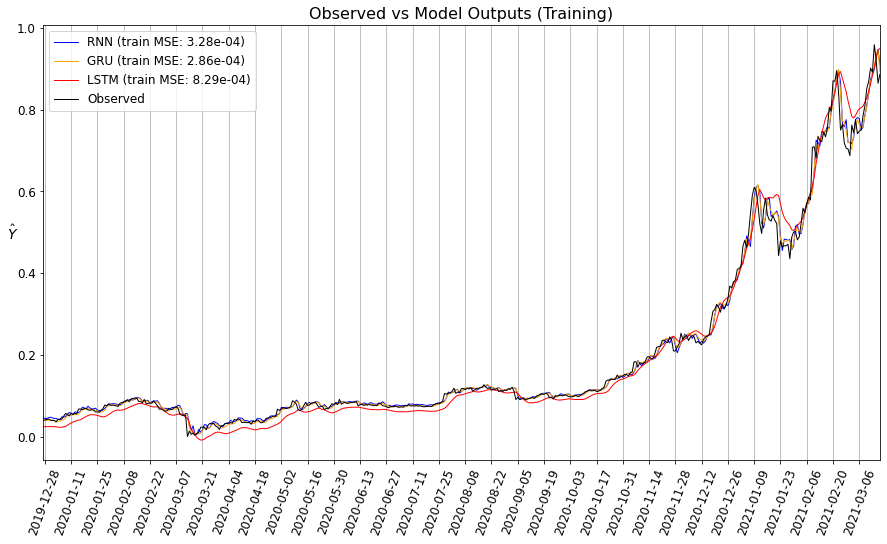

In [44]:
max_pts = 10**4
compare = params.keys()
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16)
#plt.savefig(f'../figures/univariate/{time_period}_{n_steps}_lag_training_performance.png')

### Plot Testing Predictions

Text(0.5, 1.0, 'Observed vs Model Outputs (Testing)')

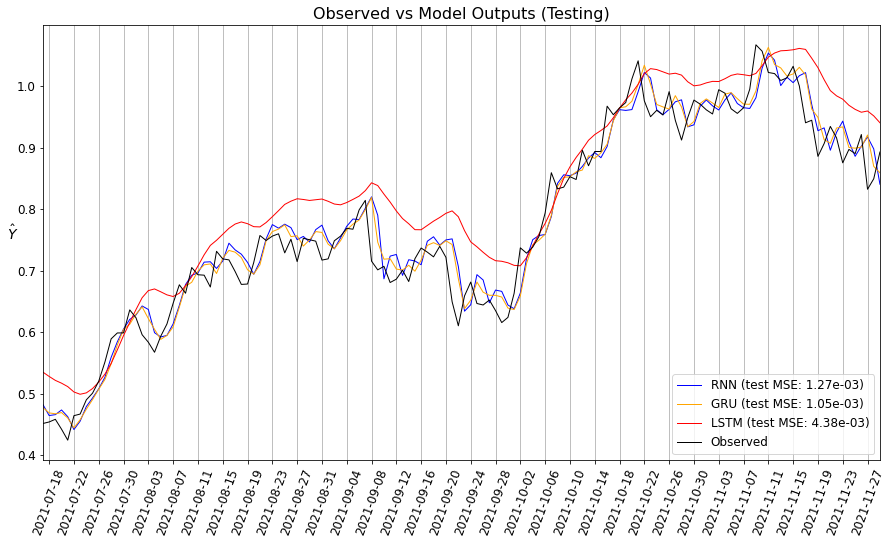

In [45]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16)
#plt.savefig(f'../figures/univariate/{time_period}_{n_steps}_lag_testing_performance.png')

### Plot Training Error

Text(0.5, 1.0, 'Observed vs Model Error (Training)')

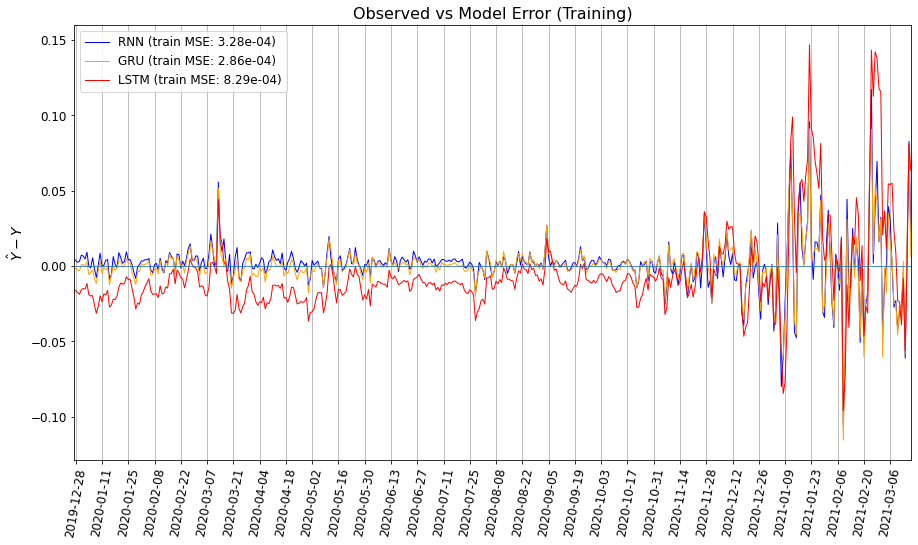

In [46]:
compare = params.keys()
l, u = (None, None) # lower and upper indices of range to plot - e.g. (None, 10000)
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds] - y_train[l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16)
#plt.savefig(f'../figures/univariate/{time_period}_{n_steps}_lag_training_performance_difference.png')

### Plot Test Error

Text(0.5, 1.0, 'Observed vs Model Error (Testing)')

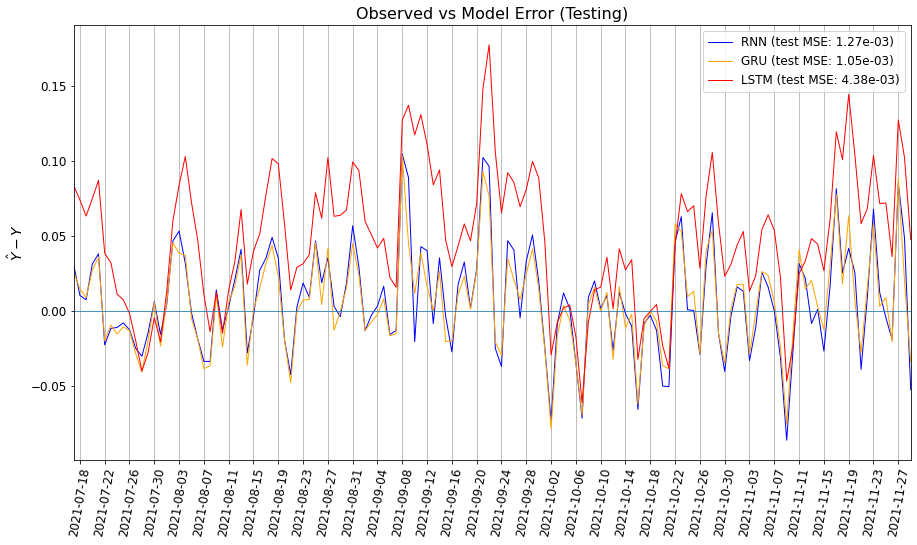

In [47]:
compare = params.keys()
l, u = (None, None) # e.g. (None, 100000) lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds] - y_test[l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Testing)', fontsize=16)
#plt.savefig(f'../figures/univariate/{dataset}/{start}_{end}_{n_steps}_lag_testing_performance_difference.png')

# Multivariate

In [33]:
dataset = "BTC-USD_hr_24"
df = pd.read_csv(f'../data/labeled_{dataset}.csv', index_col=0)
df.index = pd.to_datetime(df.index, unit='s')
target = 'target_close'

df = df.dropna()

In [34]:
use_features = ['last_low', 'last_high', "last_open", "last_close","last_volume", "current_open", target] # continuous input
n_features = len(use_features) - 1
df = df[use_features]
# already defined above
#target = ['target_close'] # continuous output
n_steps_ahead = 1 # forecasting horizon
n_steps = 7

In [ ]:
df = df['2021-01-01':]

In [35]:
# split dataset into 1-t% training, t test
def partition(df, t):
    split_index = int(len(df) * (1-t))

    df_train = df.iloc[:split_index]
    df_test = df.iloc[split_index:]

    return df_train, df_test

In [36]:
def sliding_window(data, n_steps):
    x = list()
    y = list()
    for i in range(len(data)):
        window_end = i + n_steps
        if window_end > len(data) - 1:
            break
        
        x_window = data.iloc[i:window_end, :-1]
        y_prediction = data.iloc[window_end - 1, -1]

        x.append(x_window)
        y.append(y_prediction)
    return np.array(x), np.array(y)

In [37]:
multi_X_train_full, multi_X_test = partition(df, 0.2)
# train and validation set
multi_X_train, multi_X_valid = partition(multi_X_train_full, 0.2)

# save time stamps
y_train_timestamps = multi_X_train.index[n_steps + n_steps_ahead - 1:]
y_valid_timestamps = multi_X_valid.index[n_steps + n_steps_ahead - 1:]
y_test_timestamps = multi_X_test.index[n_steps + n_steps_ahead - 1:]

## Normalize Scaling (MinMax)

In [38]:
norm_scaler = preprocessing.MinMaxScaler()
norm_scaler.fit(multi_X_train_full)
#print(f'Mean: {norm_scaler.mean_}, Std Dev: {norm_scaler.var_}')

# use training mean and std dev to avoid future bias
multi_X_train = norm_scaler.transform(multi_X_train)
multi_X_valid = norm_scaler.transform(multi_X_valid)
multi_X_test = norm_scaler.transform(multi_X_test)

# convert to df
multi_X_train = pd.DataFrame(multi_X_train, columns=use_features)
multi_X_valid = pd.DataFrame(multi_X_valid, columns=use_features)
multi_X_test = pd.DataFrame(multi_X_test, columns=use_features)

# train
x_train, y_train = sliding_window(multi_X_train, n_steps)
y_train = y_train.reshape((y_train.shape[0], 1))

# validation
x_valid, y_valid = sliding_window(multi_X_valid, n_steps)
y_valid = y_valid.reshape((y_valid.shape[0], 1))

# test
x_test, y_test = sliding_window(multi_X_test, n_steps)
y_test = y_test.reshape((y_test.shape[0], 1))

## Standardized Scaling

In [ ]:
std_scaler = preprocessing.StandardScaler()
std_scaler.fit(multi_X_train_full)
#print(f'Mean: {std_scaler.mean_}, Std Dev: {std_scaler.var_}')

# use training mean and std dev to avoid future bias
multi_X_train = std_scaler.transform(multi_X_train)
multi_X_valid = std_scaler.transform(multi_X_valid)
multi_X_test = std_scaler.transform(multi_X_test)

# convert to df
multi_X_train = pd.DataFrame(multi_X_train, columns=use_features)
multi_X_valid = pd.DataFrame(multi_X_valid, columns=use_features)
multi_X_test = pd.DataFrame(multi_X_test, columns=use_features)

# train
x_train, y_train = sliding_window(multi_X_train, n_steps)
y_train = y_train.reshape((y_train.shape[0], 1))

# validation
x_valid, y_valid = sliding_window(multi_X_valid, n_steps)
y_valid = y_valid.reshape((y_valid.shape[0], 1))

# test
x_test, y_test = sliding_window(multi_X_test, n_steps)
y_test = y_test.reshape((y_test.shape[0], 1))


In [39]:
# training
# x_train = get_lagged_features(multi_X_train[:, :n_features], n_steps, n_steps_ahead)
# y_train =  multi_X_train.values[n_steps + n_steps_ahead - 1:, -1]

#y_train_timestamps = multi_X_train.index[n_steps + n_steps_ahead - 1:]

x_train, y_train = sliding_window(multi_X_train, n_steps)
y_train = y_train.reshape((y_train.shape[0], 1))

# validation
x_valid, y_valid = sliding_window(multi_X_valid, n_steps)
y_valid = y_valid.reshape((y_valid.shape[0], 1))
#y_valid_timestamps = multi_X_valid.index[n_steps + n_steps_ahead - 1:]

# test
x_test, y_test = sliding_window(multi_X_test, n_steps)
#y_test =  multi_X_test.values[n_steps + n_steps_ahead - 1:, -1]
y_test = y_test.reshape((y_test.shape[0], 1))
#y_test_timestamps = multi_X_test.index[n_steps + n_steps_ahead - 1:]

#### Naive Forecasting Baseline

In [40]:
# y_naive = np.roll(y_valid,1)
# np.mean(keras.losses.mean_squared_error(y_valid, y_naive))
naive_baseline(y_train)

0.0018770933446627645


#### RNN Baseline

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

deep_rnn_model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[n_steps, n_features]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1)
])

deep_rnn_model.compile(loss="mse", optimizer="adam")
deep_rnn_history = deep_rnn_model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))
deep_rnn_model.evaluate(x_valid, y_valid)

In [ ]:
model = params['rnn']['model']
model.summary()
params['rnn']['pred_train'] = model.predict(x_train, verbose=0)

In [ ]:
params['rnn']['pred_train'].shape

In [ ]:
params['rnn']['pred_train'].reshape(())

In [ ]:
params['rnn']['MSE_train'] = mean_squared_error(y_train, params['rnn']['pred_train'])

In [48]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006